# notebook to explore extracted movie features from neuroscout with pyns

In [1]:
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
%matplotlib inline
import seaborn as sns
sns.set("paper", "white")

In [2]:
from pyns import Neuroscout
api = Neuroscout()

In [3]:
#there are 12 datasets
len(api.datasets.get())

12

In [4]:
datasets = api.datasets.get()
for i in datasets:
    print(i['name'], i['id'])

Budapest 27
NaturalisticNeuroimagingDatabase 28
HealthyBrainNetwork 8
SchematicNarrative 20
studyforrest 11
Raiders 10
Life 9
ParanoiaStory 18
Sherlock 21
SherlockMerlin 5
LearningTemporalStructure 19
ReadingBrainProject 29


In [5]:
budapest = datasets[0]

In [6]:
budapest['tasks']

[{'TR': 1.0,
  'avg_run_duration': 610,
  'id': 48,
  'n_runs_subject': 5,
  'n_subjects': 25,
  'name': 'movie',
  'summary': 'Movie watching'}]

### let's just look at budapest to start

In [7]:
api.runs.get(dataset_id=27, subject='sid000005',number=1)

[{'acquisition': None,
  'dataset_id': 27,
  'duration': 598.0,
  'id': 1433,
  'number': 1,
  'session': None,
  'subject': 'sid000005',
  'task': 48,
  'task_name': 'movie'}]

In [8]:
#get the run number for just BUDAPEST, SUBJECT5, PART1
run_id=api.runs.get(dataset_id=27, subject='sid000005',number=1)[0]['id']
run_duration=api.runs.get(dataset_id=27, subject='sid000005',number=1)[0]['duration']

### get just the non-fmriprep predictors and those that have a calculated mean (floats, ints, binary, etc)

In [9]:
budapest_predictors=api.predictors.get(run_id=run_id)
# for i in budapest_predictors:
#     if not i['source'] == 'fmriprep' and not i['mean'] == None:
#     #if i['source'] == 'extracted':
#             print(i['name'],i['description'])

get ids and names of predictors along with modality, if it was extracted and that was labeled

In [10]:
budapest_predictor_ids = []
budapest_predictor_names = []
budapest_predictor_modality = []

for i in budapest_predictors:
    if not i['source'] == 'fmriprep' and not i['mean'] == None:
        budapest_predictor_ids.append(i['id'])
        budapest_predictor_names.append(i['name'])
        try:
            budapest_predictor_modality.append(i['extracted_feature']['modality'])
        except:
            budapest_predictor_modality.append(None)

### load into pandas df, sort predictors by id, name, modality

In [11]:
df_predictors=pd.DataFrame(data= np.array([budapest_predictor_ids,budapest_predictor_modality,budapest_predictor_names]).T , columns=['id','modality','names'])
df_predictors = df_predictors.sort_values(by=['id','names','modality'])
budapest_predictor_ids= df_predictors['id'].to_numpy()
budapest_predictor_names= df_predictors['names'].to_numpy()
budapest_predictor_modality= df_predictors['modality'].to_numpy()


#### how many values are in each predictor??

In [12]:
# predictor_lengths = []
# for i in budapest_predictor_ids:
#     predictor_lengths.append(
#         len(api.predictor_events.get(predictor_id=i, run_id=run_id))
#                                 )
# predictor_lengths=np.array(predictor_lengths)
# print(predictor_lengths.min(), predictor_lengths.max(), predictor_lengths.mean())

### given an event... convert it from duration onset value to timeseries
- sort it (the dicts are out of order)
- convert to timeseries
- resample it to 1 hz now as a start

load an event into df, sort it by onset

In [13]:
# an_event=api.predictor_events.get(predictor_id=budapest_predictor_ids[1],run_id=run_id,stimulus_timing=True)
# #stimulus_timing flag returns addtl info including the timing relative to stimulus not run (without the offset if there is one)
# #but actualkly stimulus_timing doesn't work for all of them
# df = pd.DataFrame(columns=['onset','duration','value'])
# for i in an_event:
#     df = df.append({'onset': i['onset'], 'duration': i['duration'], 'value': i['value']}, ignore_index=True)
# df = df.sort_values(by='onset')
# df

In [14]:
import math
all_feats = []
for pred_id in budapest_predictor_ids:
    an_event=api.predictor_events.get(predictor_id=pred_id,run_id=run_id,stimulus_timing=True)
    data = np.zeros((int(run_duration)))
    for i in an_event:
        start = round(i['onset'])
        stop = start + math.ceil(i['duration'])
        value = i['value']
        #onset=round(onset)
        try:
            data[start:stop]=value
        except:
            #print()
            print(f'skipped {value}')

    all_feats.append(data)
#all_feats is length = # predictors each predictor is size = run duration

In [15]:
all_feats = np.asarray(all_feats)
all_feats.shape

(192, 598)

In [16]:
df = pd.DataFrame(data=all_feats.T,columns = budapest_predictor_names)

In [17]:
df_corr = df.corr()

## plot correlation matrix

Text(0.5, 1.0, 'budapest part 1 corr')

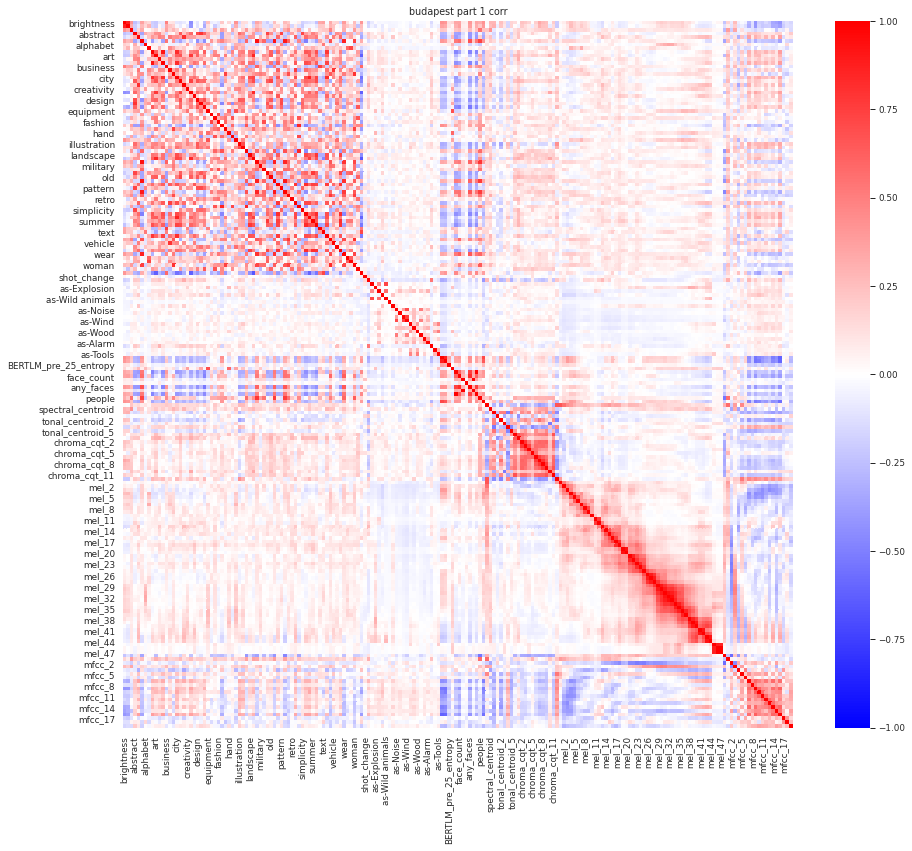

In [85]:
# Generate a mask for the upper triangle
mask = np.triu(np.ones_like(df_corr, dtype=np.bool))

# Set up the matplotlib figure
f, ax = plt.subplots(figsize=(15, 13))

# Generate a custom diverging colormap
#cmap = sns.diverging_palette(220, 10, as_cmap=True)

# Draw the heatmap with the mask and correct aspect ratio
sns.heatmap(df_corr, cmap = 'bwr', vmin=-1, vmax=1)
plt.title("budapest part 1 corr")

## plot dcor matrix

In [17]:
import dcor
result = df.apply(lambda col1: df.apply(lambda col2: dcor.distance_correlation(col1, col2)))
result

,brightness,vibrance,sharpness,abstract,action,adult,alphabet,animal,architecture,art,...,mfcc_10,mfcc_11,mfcc_12,mfcc_13,mfcc_14,mfcc_15,mfcc_16,mfcc_17,mfcc_18,mfcc_19
brightness,1.000000,0.877499,0.388353,0.378744,0.230850,0.415770,0.233442,0.239423,0.354038,0.438184,...,0.223674,0.251527,0.203940,0.218145,0.346133,0.352560,0.433359,0.171249,0.234483,0.186562
vibrance,0.877499,1.000000,0.363154,0.309419,0.213634,0.351422,0.220039,0.320464,0.264174,0.346432,...,0.213960,0.263053,0.215864,0.204047,0.339040,0.326352,0.403005,0.180348,0.202611,0.183571
sharpness,0.388353,0.363154,1.000000,0.336600,0.176004,0.305429,0.104199,0.152568,0.178867,0.240840,...,0.187563,0.170101,0.143225,0.109215,0.141375,0.254361,0.171132,0.158623,0.120232,0.170126
abstract,0.378744,0.309419,0.336600,1.000000,0.338332,0.423029,0.372714,0.346377,0.300856,0.473214,...,0.208622,0.151269,0.123159,0.109286,0.149562,0.201987,0.238131,0.075093,0.124717,0.192719
action,0.230850,0.213634,0.176004,0.338332,1.000000,0.249479,0.184084,0.369824,0.417934,0.378386,...,0.257285,0.139182,0.276908,0.130265,0.280197,0.082863,0.342368,0.192792,0.122518,0.115255
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
mfcc_15,0.352560,0.326352,0.254361,0.201987,0.082863,0.231942,0.096562,0.115797,0.140849,0.137504,...,0.446490,0.330664,0.261145,0.402445,0.513563,1.000000,0.554314,0.309088,0.164856,0.376360
mfcc_16,0.433359,0.403005,0.171132,0.238131,0.342368,0.379770,0.079595,0.118296,0.369515,0.308987,...,0.474388,0.433348,0.453444,0.371734,0.604347,0.554314,1.000000,0.223627,0.235117,0.307409
mfcc_17,0.171249,0.180348,0.158623,0.075093,0.192792,0.086050,0.077717,0.091098,0.145831,0.135361,...,0.127180,0.214786,0.152374,0.253305,0.145620,0.309088,0.223627,1.000000,0.374029,0.195826
mfcc_18,0.234483,0.202611,0.120232,0.124717,0.122518,0.202240,0.161213,0.167053,0.129994,0.116401,...,0.173839,0.206797,0.273661,0.235826,0.273231,0.164856,0.235117,0.374029,1.000000,0.292316


In [ ]:
# Generate a mask for the upper triangle
mask = np.triu(np.ones_like(result, dtype=np.bool))

# Set up the matplotlib figure
f, ax = plt.subplots(figsize=(15, 13))

# Generate a custom diverging colormap
#cmap = sns.diverging_palette(220, 10, as_cmap=True)

# Draw the heatmap with the mask and correct aspect ratio
sns.heatmap(result, cmap = 'bwr', vmin=0, vmax=1, center=0)
plt.title("budapest part 1 dcor")


# mask = np.triu(np.ones_like(result, dtype=bool))

# # Set up the matplotlib figure
# f, ax = plt.subplots(figsize=(15, 12))

# # Generate a custom diverging colormap
# #cmap = sns.diverging_palette(230, 20, as_cmap=True)
# cmap = 'bwr'

# # Draw the heatmap with the mask and correct aspect ratio
# sns.heatmap(result, mask=mask, cmap=cmap, vmax=1, vmin=0, center=0,
#             square=True, linewidths=.5, annot=True, fmt=".2g",  cbar_kws={"shrink": .5})
# plt.title('Distance Correlation')

## now try hierarchical clustering

In [87]:
from scipy.cluster.hierarchy import dendrogram
from sklearn.cluster import AgglomerativeClustering

In [92]:
def plot_dendrogram(model, **kwargs):
    # Create linkage matrix and then plot the dendrogram

    # create the counts of samples under each node
    counts = np.zeros(model.children_.shape[0])
    n_samples = len(model.labels_)
    for i, merge in enumerate(model.children_):
        current_count = 0
        for child_idx in merge:
            if child_idx < n_samples:
                current_count += 1  # leaf node
            else:
                current_count += counts[child_idx - n_samples]
        counts[i] = current_count

    linkage_matrix = np.column_stack([model.children_, model.distances_,
                                      counts]).astype(float)

    # Plot the corresponding dendrogram
    dendrogram(linkage_matrix, **kwargs)


In [101]:
# model = AgglomerativeClustering(distance_threshold=0.1, n_clusters=None, linkage= 'complete', affinity='precomputed')
# model.fit(result)

model = AgglomerativeClustering(distance_threshold=None, n_clusters=4, linkage= 'complete', affinity='precomputed')
model.fit(result)

AgglomerativeClustering(affinity='precomputed', linkage='complete',
                        n_clusters=4)

In [102]:
model.labels_

array([0, 3, 1, 0, 2, 3, 1, 3, 2, 0, 3, 3, 1, 3, 0, 0, 0, 0, 2, 2, 1, 3,
       0, 1, 0, 2, 2, 0, 0, 1, 1, 3, 1, 1, 0, 0, 3, 1, 1, 2, 0, 0, 0, 2,
       0, 3, 0, 0, 1, 1, 1, 2, 1, 2, 1, 1, 2, 1, 1, 2, 0, 0, 2, 1, 1, 1,
       1, 0, 3, 1, 0, 1, 1, 1, 2, 3, 1, 0, 2, 2, 2, 2, 0, 0, 1, 3, 1, 0,
       0, 3, 0, 1, 2, 3, 1, 1, 1, 0, 1, 0, 1, 0, 0, 0, 1, 2, 3, 0, 1, 3,
       1, 3, 1, 1, 0, 1, 2, 1, 3, 2, 1, 0, 2, 0, 1, 0, 1, 0, 1, 0, 3, 1,
       0, 3, 1, 3, 2, 1, 1, 2, 0, 2, 0, 1, 0, 1, 2, 0, 0, 1, 0, 1, 0, 2,
       1, 0, 3, 1, 2, 0, 1, 2, 3, 0, 2, 1, 3, 0, 1, 0, 3, 1, 3, 1, 0, 1,
       0, 0, 2, 1, 1, 3, 0, 0, 1, 0, 2, 0, 0, 2, 0, 1])

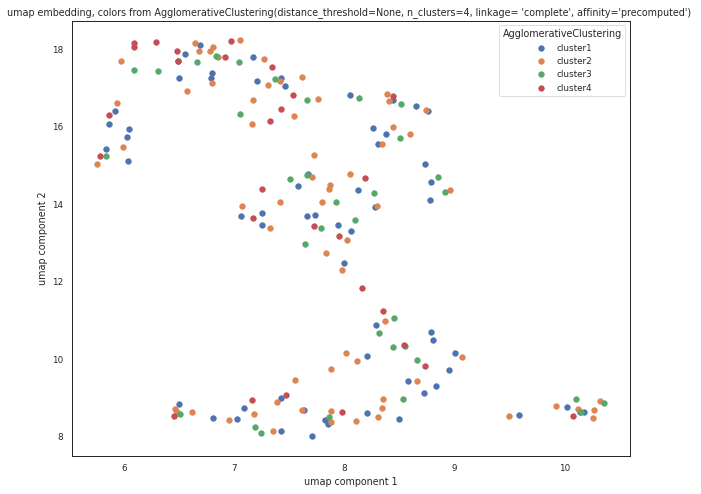

In [104]:
fig, ax = plt.subplots(figsize=((10,8)))
cdict = {0: 'cluster1', 1: 'cluster2', 2: 'cluster3', 3: 'cluster4'}

for category in np.unique(model.labels_):
    ix = np.where(model.labels_ == category)
    ax.scatter(u[:, 0][ix], u[:, 1][ix], label = cdict[category], s = 30, alpha = 1, cmap = 'gist_rainbow')
#     plt.scatter(projected[:, 0], projected[:, 1],
#             alpha=0.8, c=as_classes, label=as_classes_label,cmap = 'gist_rainbow')
plt.xlabel('umap component 1')
plt.ylabel('umap component 2')
plt.title('umap embedding, colors from AgglomerativeClustering(distance_threshold=None, n_clusters=4, linkage= \'complete\', affinity=\'precomputed\') ')
#plt.colorbar();
ax.legend(title="AgglomerativeClustering")
# plt.xlim((-0.2,1))
# plt.ylim((-0.2,0.5))

In [93]:
#plot_dendrogram(model)
plot_dendrogram(model, truncate_mode='level', p=4)

AttributeError: 'AgglomerativeClustering' object has no attribute 'distances_'

### try umap

In [18]:
import umap
# n_neighbors=25
# min_dist=0
# n_components=2
# metric='euclidean'

# fit = umap.UMAP(n_neighbors=n_neighbors,
#     min_dist=min_dist,
#     n_components=n_components,
#     metric=metric)

umap=umap.UMAP(metric='correlation')

#%time u = fit.fit_transform(all_data[:,:,0])


In [19]:
%time u = umap.fit_transform(df.T)

CPU times: user 13 s, sys: 663 ms, total: 13.7 s
Wall time: 12.5 s


In [20]:
u.shape

(192, 2)

In [21]:
budapest_predictor_modality_ind = np.zeros(budapest_predictor_modality.shape)

In [22]:
budapest_predictor_modality_int = np.where(budapest_predictor_modality == None, '', budapest_predictor_modality)

In [23]:
modality_lookup, foo, modality_inverse= np.unique(budapest_predictor_modality_int,return_index=True,return_inverse=True)

In [24]:
modality_lookup

array(['', 'audio', 'image', 'text'], dtype=object)

In [25]:
modality_inverse

array([2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2,
       2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2,
       2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2,
       2, 2, 2, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 0, 3, 0, 2, 0, 0, 0, 0, 0, 0, 0, 2, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1])

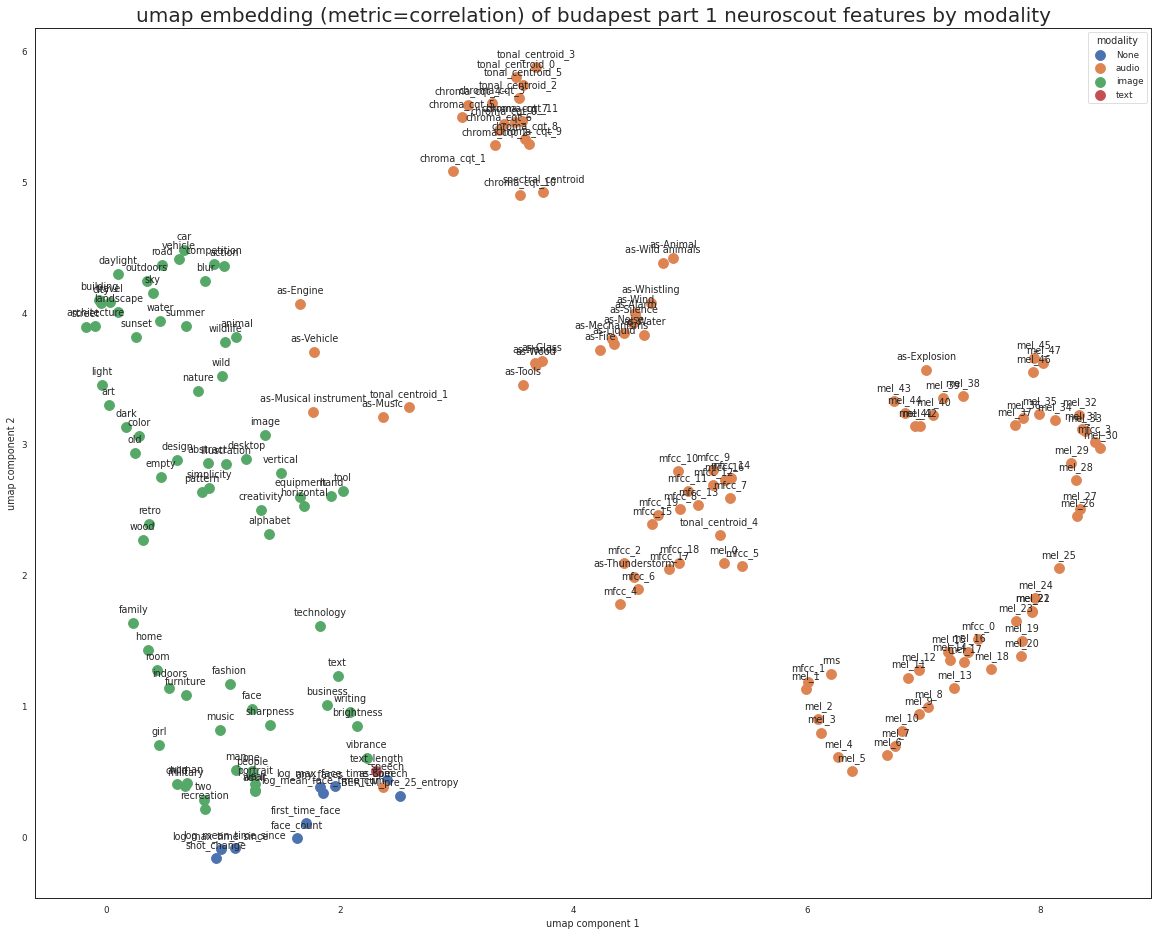

In [26]:
fig, ax = plt.subplots(figsize=((20,16)))
cdict = {0: 'None', 1: 'audio', 2: 'image', 3: 'text'}


for category in np.unique(modality_inverse):
    ix = np.where(modality_inverse == category)
    ax.scatter(u[:, 0][ix], u[:, 1][ix], label = cdict[category], s = 100, alpha = 1, cmap = 'gist_rainbow')
#     plt.scatter(projected[:, 0], projected[:, 1],
#             alpha=0.8, c=as_classes, label=as_classes_label,cmap = 'gist_rainbow')
for i,s in enumerate(budapest_predictor_names):
    plt.text(u[i,0],u[i,1]+0.08,s,ha='center')
plt.xlabel('umap component 1')
plt.ylabel('umap component 2')
plt.title('umap embedding (metric=correlation) of budapest part 1 neuroscout features by modality',fontdict = {'fontsize' : 20})
#plt.colorbar();
ax.legend(title="modality")
# plt.xlim((-0.2,1))
# plt.ylim((-0.2,0.5))

## lets turn the distance correlation matrix into an undirected graph and find a good threshold

In [27]:
import networkx as nx

In [39]:
dcor_matrix = result.values

In [65]:
np.fill_diagonal(dcor_matrix, 0) 

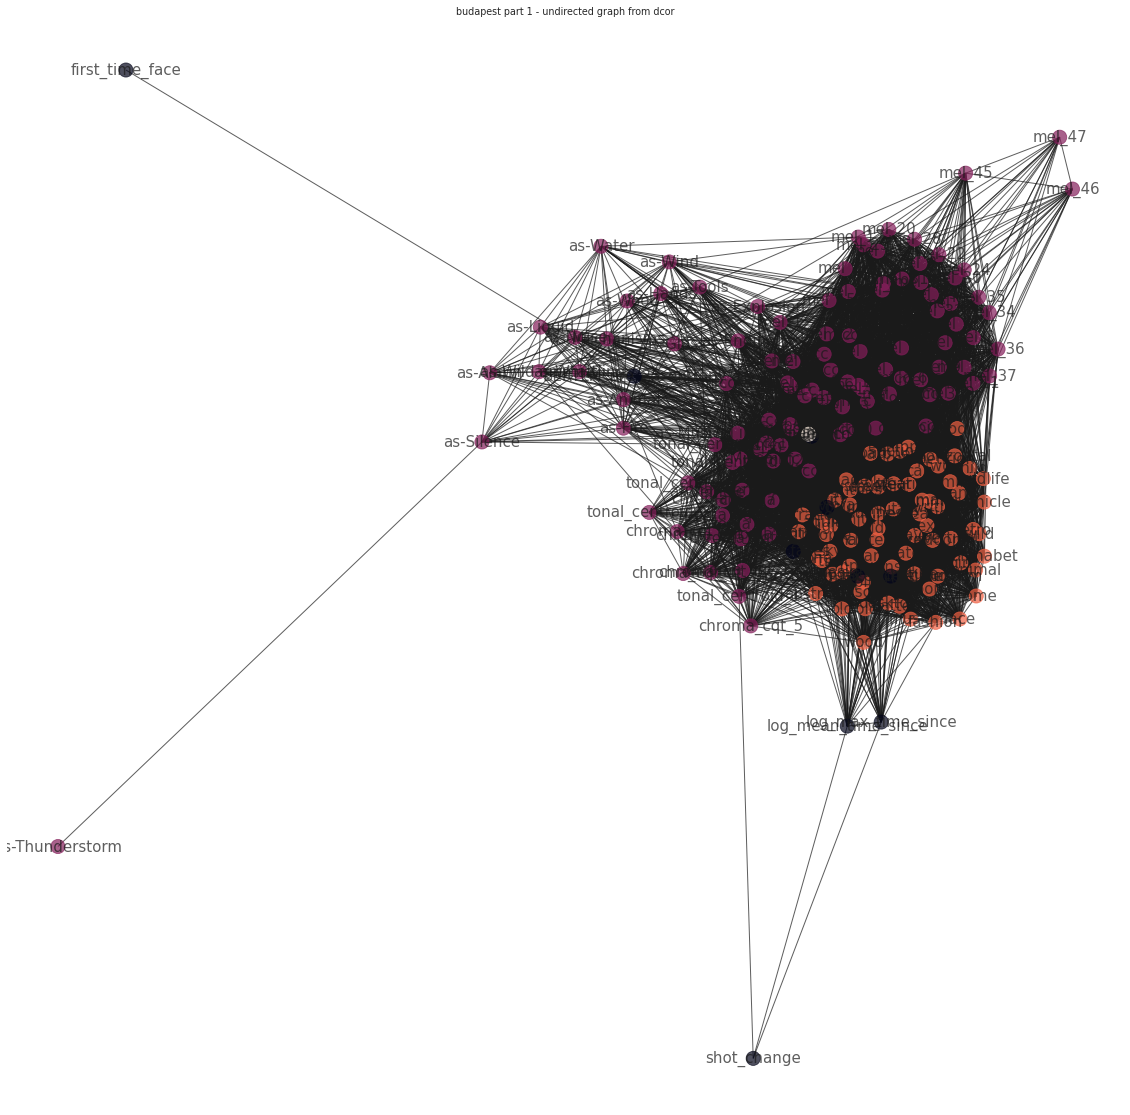

In [67]:
dcor_matrix_g = nx.Graph(incoming_graph_data=dcor_matrix)
mapping = dict(zip(dcor_matrix_thresh_g, budapest_predictor_names))
dcor_matrix_thresh_g = nx.relabel_nodes(dcor_matrix_thresh_g, mapping) 

plt.figure(figsize=(20,20))
plt.title(f'budapest part 1 - undirected graph from dcor')
nx.draw(dcor_matrix_thresh_g, alpha = 0.7, node_size=200, node_color=modality_inverse/3, with_labels=True, font_size=15)
#plt.show()

In [29]:
thresh=0.15

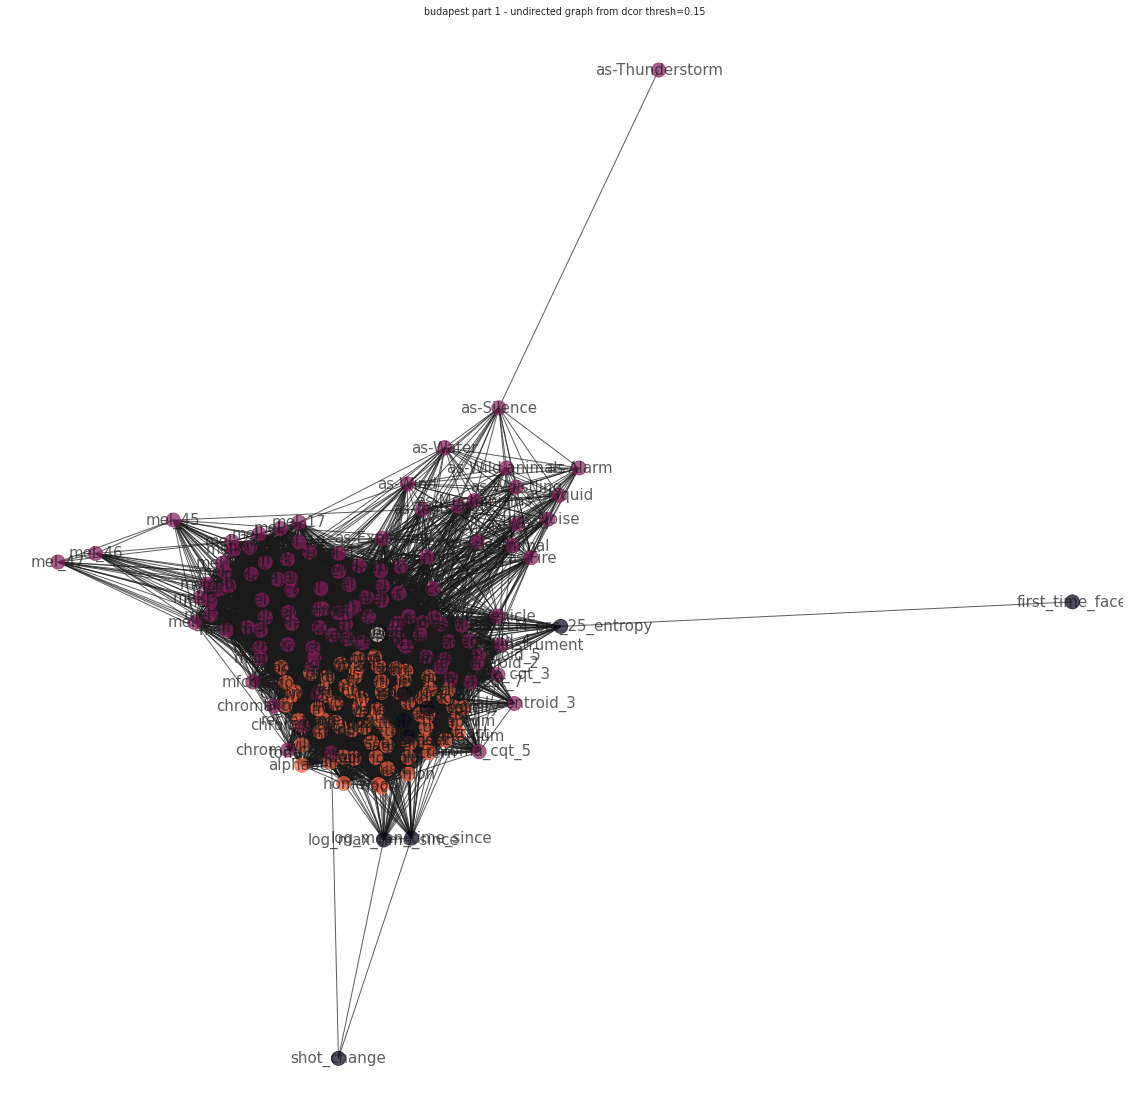

In [30]:
dcor_matrix_thresh=np.where(dcor_matrix>thresh,1,0)

dcor_matrix_thresh_g = nx.Graph(incoming_graph_data=dcor_matrix_thresh)
mapping = dict(zip(dcor_matrix_thresh_g, budapest_predictor_names))
dcor_matrix_thresh_g = nx.relabel_nodes(dcor_matrix_thresh_g, mapping) 

plt.figure(figsize=(20,20))
plt.title(f'budapest part 1 - undirected graph from dcor thresh={str(thresh)}')
nx.draw(dcor_matrix_thresh_g, alpha = 0.7, node_size=200, node_color=modality_inverse/3, with_labels=True, font_size=15)
#plt.show()

## Now lets use Communities to look at community structure

### Louvain method:

In [85]:
from communities.visualization import draw_communities
from communities.algorithms import louvain_method

In [86]:
communities, frames = louvain_method(dcor_matrix)

In [87]:
len(communities)

3

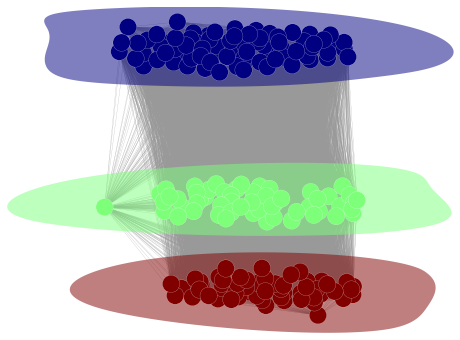

<AxesSubplot:>

In [88]:
draw_communities(dcor_matrix, communities)

In [89]:
communities_plot=np.zeros(modality_inverse.shape)
cdict = {}

for i,c in enumerate(communities):
    cdict[i]=f'group {i+1}'
    for c_c in list(communities[i]):
        communities_plot[c_c]=i

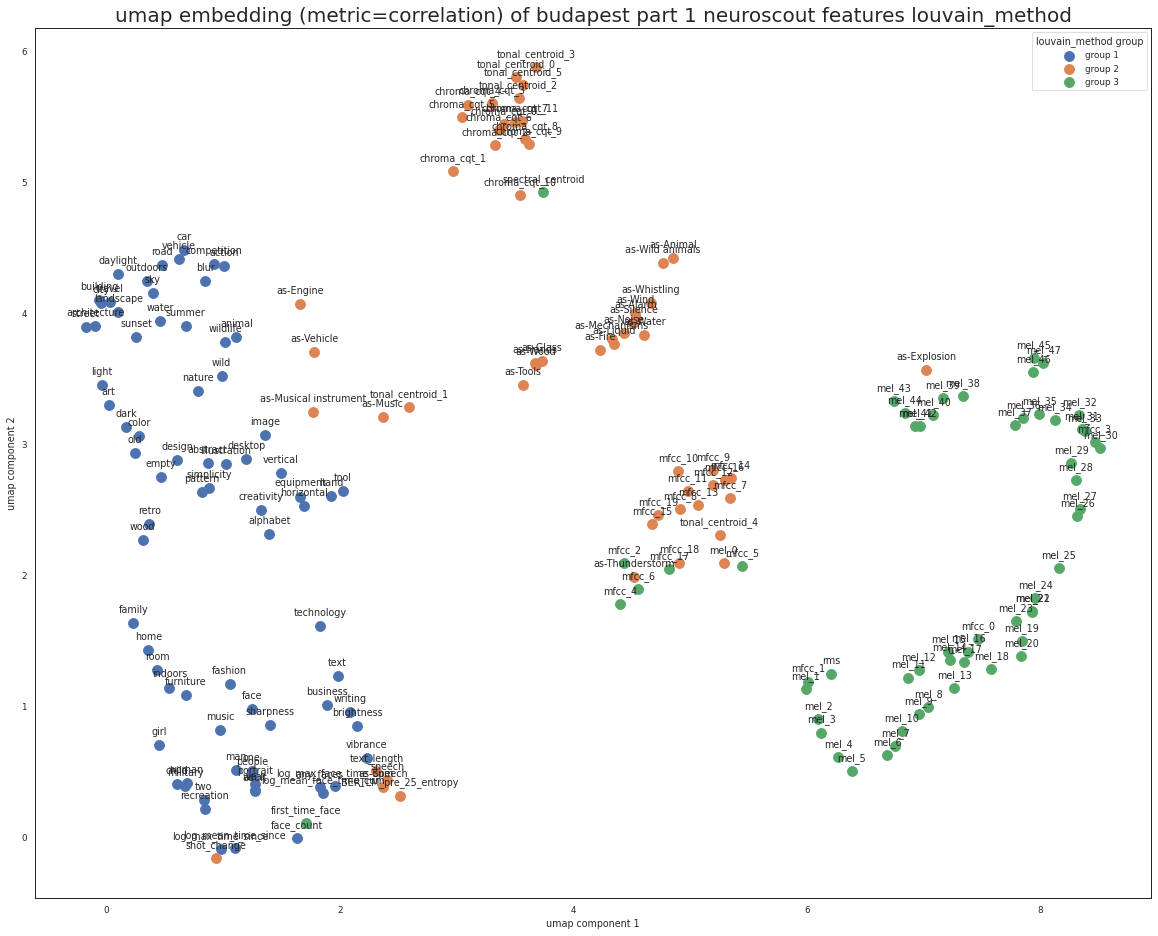

In [90]:
fig, ax = plt.subplots(figsize=((20,16)))
for category in np.unique(communities_plot):
    ix = np.where(communities_plot == category)
    ax.scatter(u[:, 0][ix], u[:, 1][ix], label = cdict[category], s = 100, alpha = 1, cmap = 'gist_rainbow')
#     plt.scatter(projected[:, 0], projected[:, 1],
#             alpha=0.8, c=as_classes, label=as_classes_label,cmap = 'gist_rainbow')
for i,s in enumerate(budapest_predictor_names):
    plt.text(u[i,0],u[i,1]+0.08,s,ha='center')
plt.xlabel('umap component 1')
plt.ylabel('umap component 2')
plt.title('umap embedding (metric=correlation) of budapest part 1 neuroscout features louvain_method',fontdict = {'fontsize' : 20})
#plt.colorbar();
ax.legend(title="louvain_method group")
# plt.xlim((-0.2,1))
# plt.ylim((-0.2,0.5))

## Girvan Newman

In [109]:
from communities.algorithms import girvan_newman

In [ ]:
communities, frames = girvan_newman(dcor_matrix)

In [ ]:
len(communities)

In [ ]:
draw_communities(dcor_matrix, communities)

In [ ]:
communities_plot=np.zeros(modality_inverse.shape)
cdict = {}

for i,c in enumerate(communities):
    cdict[i]=f'group {i+1}'
    for c_c in list(communities[i]):
        communities_plot[c_c]=i

In [ ]:
budapest_predictor_ids.shape

In [ ]:

fig, ax = plt.subplots(figsize=((20,16)))
for category in np.unique(communities_plot):
    ix = np.where(communities_plot == category)
    ax.scatter(u[:, 0][ix], u[:, 1][ix], label = cdict[category], s = 100, alpha = 1, cmap = 'gist_rainbow')
#     plt.scatter(projected[:, 0], projected[:, 1],
#             alpha=0.8, c=as_classes, label=as_classes_label,cmap = 'gist_rainbow')
for i,s in enumerate(budapest_predictor_names):
    plt.text(u[i,0],u[i,1]+0.08,s,ha='center')
plt.xlabel('umap component 1')
plt.ylabel('umap component 2')
plt.title('umap embedding (metric=correlation) of budapest part 1 neuroscout features girvan_newman',fontdict = {'fontsize' : 20})
#plt.colorbar();
ax.legend(title="girvan_newman group")
# plt.xlim((-0.2,1))
# plt.ylim((-0.2,0.5))

## Hierarchichal CLustering

In [91]:
from communities.algorithms import hierarchical_clustering

In [92]:
communities = hierarchical_clustering(dcor_matrix,n=5)

In [93]:
len(communities)

5

/om2/user/jsmentch/anaconda/envs/pliers/lib/python3.8/site-packages/scipy/interpolate/_fitpack_impl.py:226: RuntimeWarning: Setting x[0][8]=x[0][0]
  warnings.warn(RuntimeWarning('Setting x[%d][%d]=x[%d][0]' %
/om2/user/jsmentch/anaconda/envs/pliers/lib/python3.8/site-packages/scipy/interpolate/_fitpack_impl.py:226: RuntimeWarning: Setting x[1][8]=x[1][0]
  warnings.warn(RuntimeWarning('Setting x[%d][%d]=x[%d][0]' %


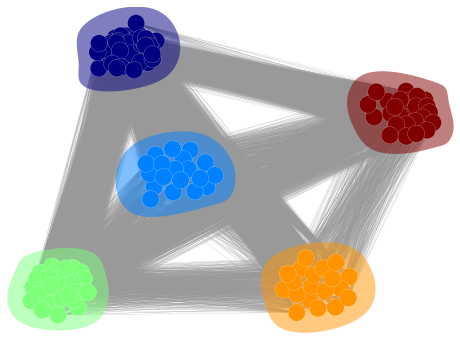

<AxesSubplot:>

In [94]:
draw_communities(dcor_matrix, communities)

In [95]:
communities_plot=np.zeros(modality_inverse.shape)
cdict = {}

for i,c in enumerate(communities):
    cdict[i]=f'group {i+1}'
    for c_c in list(communities[i]):
        communities_plot[c_c]=i

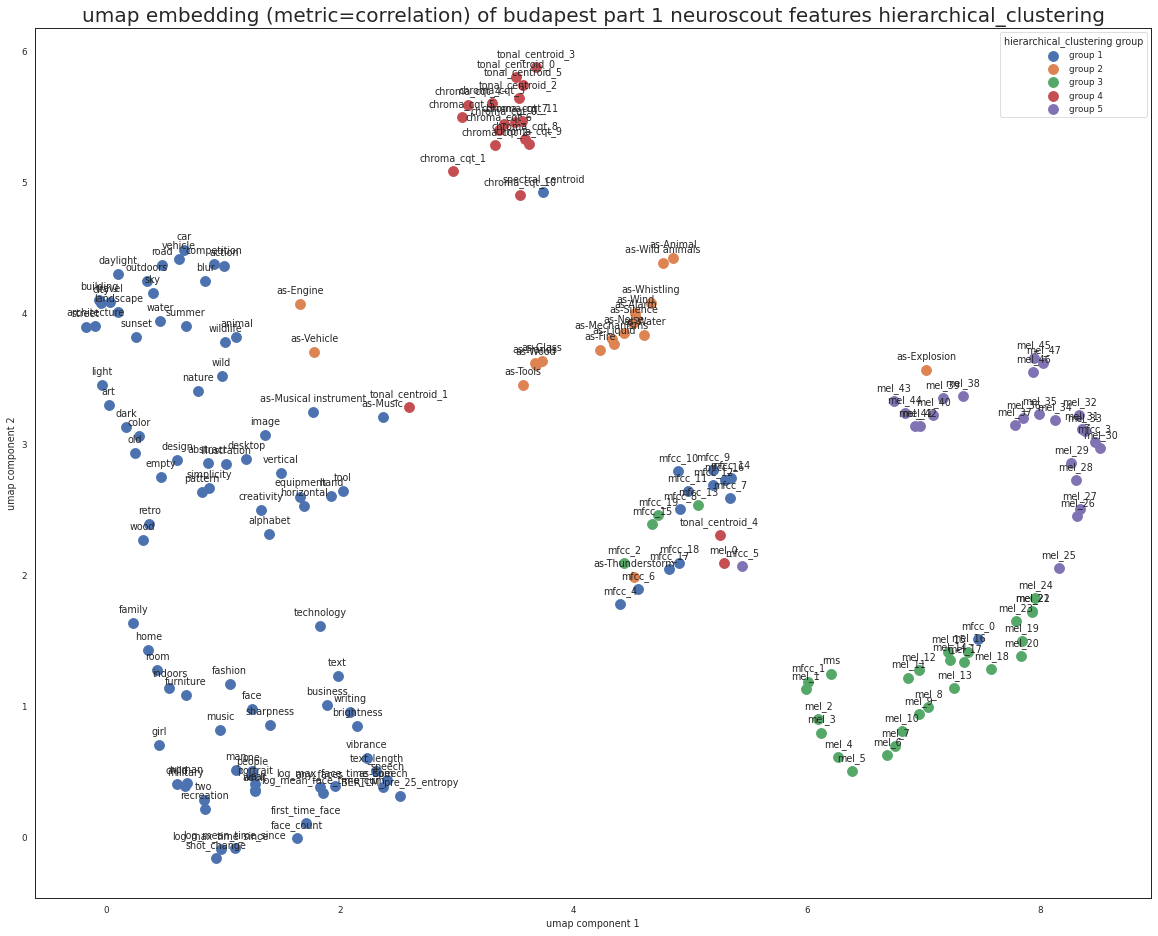

In [96]:

fig, ax = plt.subplots(figsize=((20,16)))
for category in np.unique(communities_plot):
    ix = np.where(communities_plot == category)
    ax.scatter(u[:, 0][ix], u[:, 1][ix], label = cdict[category], s = 100, alpha = 1, cmap = 'gist_rainbow')
#     plt.scatter(projected[:, 0], projected[:, 1],
#             alpha=0.8, c=as_classes, label=as_classes_label,cmap = 'gist_rainbow')
for i,s in enumerate(budapest_predictor_names):
    plt.text(u[i,0],u[i,1]+0.08,s,ha='center')
plt.xlabel('umap component 1')
plt.ylabel('umap component 2')
plt.title('umap embedding (metric=correlation) of budapest part 1 neuroscout features hierarchical_clustering',fontdict = {'fontsize' : 20})
#plt.colorbar();
ax.legend(title="hierarchical_clustering group")
# plt.xlim((-0.2,1))
# plt.ylim((-0.2,0.5))

## spectral_clustering

In [97]:
from communities.algorithms import spectral_clustering

In [104]:
communities = spectral_clustering(dcor_matrix,k=5)

In [105]:
len(communities)

5

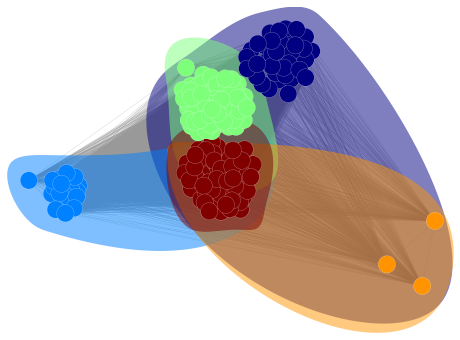

<AxesSubplot:>

In [106]:
draw_communities(dcor_matrix, communities)

In [107]:
communities_plot=np.zeros(modality_inverse.shape)
cdict = {}

for i,c in enumerate(communities):
    cdict[i]=f'group {i+1}'
    for c_c in list(communities[i]):
        communities_plot[c_c]=i

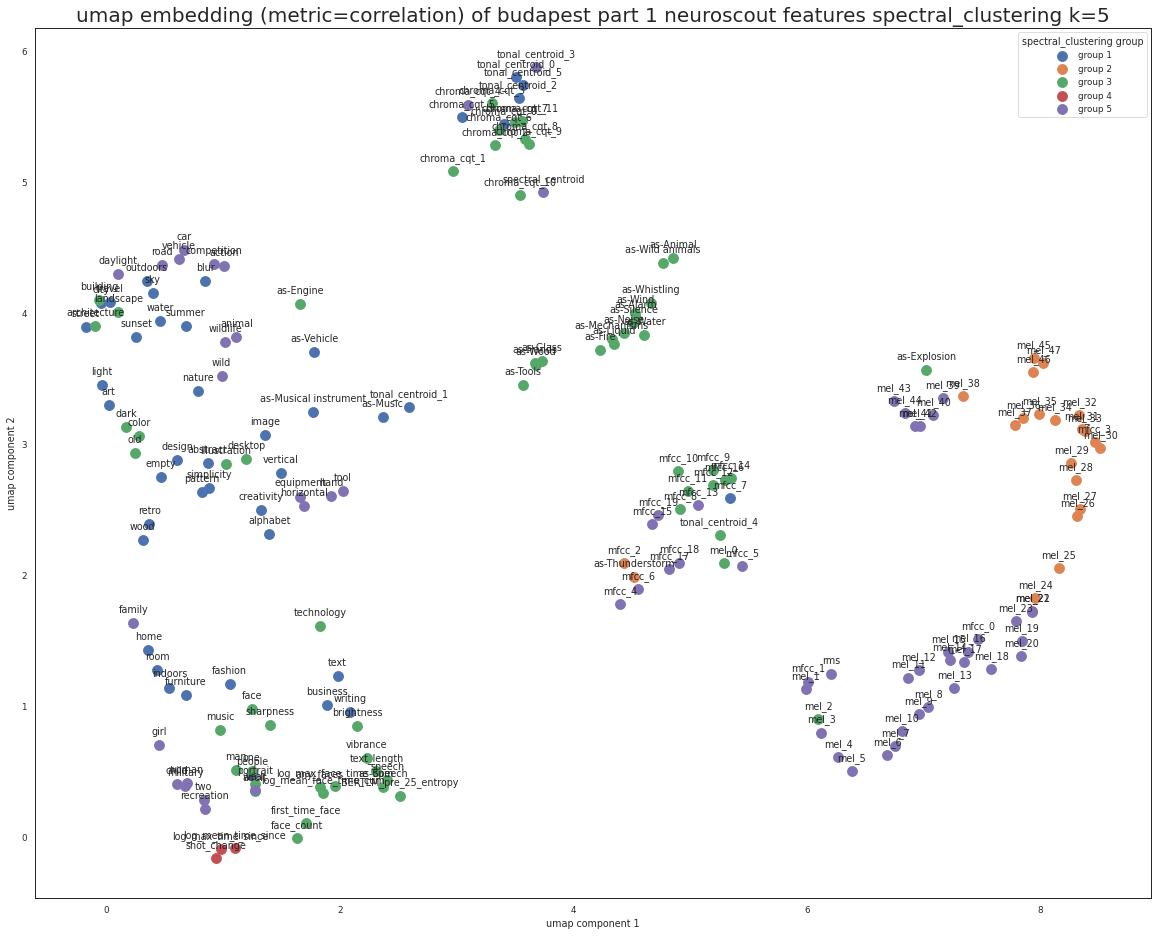

In [108]:

fig, ax = plt.subplots(figsize=((20,16)))
for category in np.unique(communities_plot):
    ix = np.where(communities_plot == category)
    ax.scatter(u[:, 0][ix], u[:, 1][ix], label = cdict[category], s = 100, alpha = 1, cmap = 'gist_rainbow')
#     plt.scatter(projected[:, 0], projected[:, 1],
#             alpha=0.8, c=as_classes, label=as_classes_label,cmap = 'gist_rainbow')
for i,s in enumerate(budapest_predictor_names):
    plt.text(u[i,0],u[i,1]+0.08,s,ha='center')
plt.xlabel('umap component 1')
plt.ylabel('umap component 2')
plt.title('umap embedding (metric=correlation) of budapest part 1 neuroscout features spectral_clustering k=5',fontdict = {'fontsize' : 20})
#plt.colorbar();
ax.legend(title="spectral_clustering group")
# plt.xlim((-0.2,1))
# plt.ylim((-0.2,0.5))

## bron_kerbosch

In [58]:
from communities.algorithms import bron_kerbosch

In [62]:
communities = bron_kerbosch(dcor_matrix, pivot=True)

In [60]:
len(communities)

0

In [ ]:
draw_communities(dcor_matrix_thresh, communities)

In [ ]:
communities_plot=np.zeros(modality_inverse.shape)
cdict = {}

for i,c in enumerate(communities):
    cdict[i]=f'group {i+1}'
    for c_c in list(communities[i]):
        communities_plot[c_c]=i

In [ ]:

fig, ax = plt.subplots(figsize=((20,16)))
for category in np.unique(communities_plot):
    ix = np.where(communities_plot == category)
    ax.scatter(u[:, 0][ix], u[:, 1][ix], label = cdict[category], s = 100, alpha = 1, cmap = 'gist_rainbow')
#     plt.scatter(projected[:, 0], projected[:, 1],
#             alpha=0.8, c=as_classes, label=as_classes_label,cmap = 'gist_rainbow')
for i,s in enumerate(budapest_predictor_names):
    plt.text(u[i,0],u[i,1]+0.08,s,ha='center')
plt.xlabel('umap component 1')
plt.ylabel('umap component 2')
plt.title('umap embedding (metric=correlation) of budapest part 1 neuroscout features bron_kerbosch',fontdict = {'fontsize' : 20})
#plt.colorbar();
ax.legend(title="bron_kerbosch group")
# plt.xlim((-0.2,1))
# plt.ylim((-0.2,0.5))